In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import os

In [13]:
image_size = 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)
data_path = 'Testing'  

generator = datagen.flow_from_directory(
    data_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_names = list(generator.class_indices.keys())
num_classes = len(class_names)

Found 1200 images belonging to 4 classes.


In [14]:
# Load trained models
vgg19 = load_model("VGG19_brain_tumor.h5")
mobilenet = load_model("MobileNetV2_brain_tumor.h5")

# InceptionV3 expects 299x299 input
datagen_299 = ImageDataGenerator(rescale=1./255)
generator_299 = datagen_299.flow_from_directory(
    data_path,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

inception = load_model("InceptionV3_brain_tumor.h5")

# Get feature extractors (exclude last softmax layer)
vgg19_feat = Model(inputs=vgg19.input, outputs=vgg19.layers[-2].output)
mobilenet_feat = Model(inputs=mobilenet.input, outputs=mobilenet.layers[-2].output)
inception_feat = Model(inputs=inception.input, outputs=inception.layers[-2].output)

Found 1200 images belonging to 4 classes.


In [15]:
# Extract features
features_vgg19 = vgg19_feat.predict(generator, verbose=1)
features_mobilenet = mobilenet_feat.predict(generator, verbose=1)
features_inception = inception_feat.predict(generator_299, verbose=1)

# Concatenate all features
combined_features = np.concatenate([features_vgg19, features_mobilenet, features_inception], axis=1)

# Get true labels
labels = generator.classes

C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 187s 5s/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 495ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step


In [16]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42, stratify=labels)

# Train SVM
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)

# Predict
y_pred = svm_model.predict(X_test)
y_proba = svm_model.predict_proba(X_test)

In [17]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

Accuracy: 0.9958
Precision: 0.9959
Recall: 0.9958
F1-Score: 0.9958
AUC-ROC: 1.0000


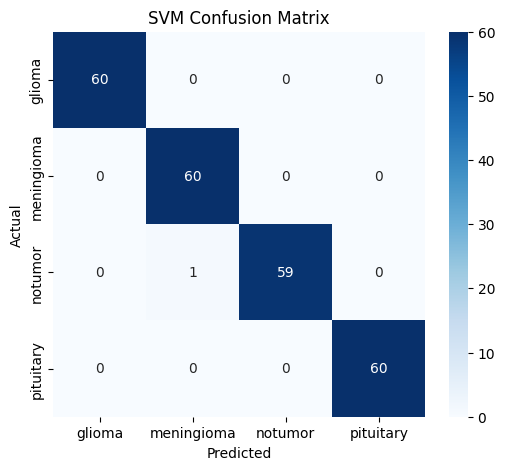

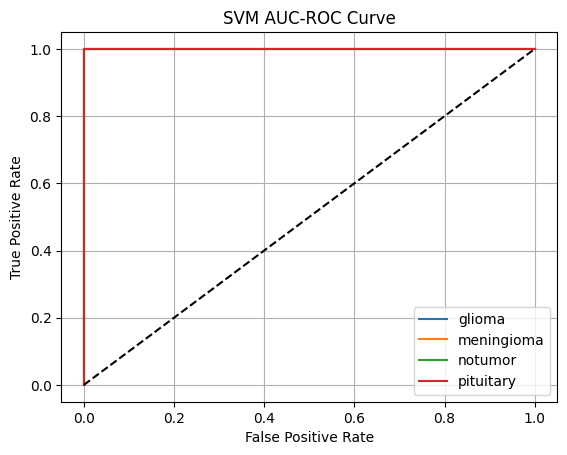

In [18]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC for all classes
fpr = {}
tpr = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]}")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('SVM AUC-ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [20]:
results_path = 'all_model_results.csv'

model_name = 'SVM_Ensemble'

new_row = {
    "Model": model_name,
    "Accuracy": round(accuracy, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "Specificity": round((tn / (tn + fp)) if (tn + fp) != 0 else 0, 4),
    "F1-Score": round(f1, 4),
    "auc-roc": round(auc, 4),
    "TP": int(tp),
    "TN": int(tn),
    "FP": int(fp),
    "FN": int(fn)
}

# Load existing and append
df = pd.read_csv(results_path)
df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
df.to_csv(results_path, index=False)
print("SVM ensemble results saved.")

SVM ensemble results saved.
